
# LO Drell–Yan: differential distribution in invariant mass (SciPy integration)

This notebook computes the **leading-order (LO)** Drell–Yan spectrum

\[
pp \to \ell^+\ell^- + X
\qquad\Rightarrow\qquad
\frac{d\sigma}{dM}
\]

as a function of the dilepton invariant mass \(M\), using **LHAPDF** PDFs and a **rapidity integral** at fixed \(M\).

Integration is performed with **SciPy** (`scipy.integrate.quad`) rather than VEGAS.

**Physics assumptions (LO):**
- Incoming hadrons: protons (use any PDF set in LHAPDF)
- Partonic channel: \(q\bar q \to \ell^+\ell^-\) (no QCD radiation)
- Factorisation/renormalisation scale: \(\mu_F^2=\mu_R^2=M^2\) (editable)
- Inclusive over dilepton angles

You can switch between:
- `"photon"`: pure-\(\gamma\) term
- `"gammaZ"`: \(\gamma/Z\) including interference


In [1]:

import numpy as np
import matplotlib.pyplot as plt

from scipy.integrate import quad
import lhapdf



## Configuration


In [2]:

# --- Collider / PDF configuration ---
sqrt_s = 14_000.0  # GeV (LHC-like default). Change freely.
s = sqrt_s**2

pdf_set_name = "PDF4LHC21_40"
pset = lhapdf.getPDFSet(pdf_set_name)
pdfs = pset.mkPDFs()

replica = 0  # 0=central, 1..N-1 = members
pdf = pdfs[replica]

# --- Numerical integration controls ---
# quad absolute/relative tolerances (tune if needed)
epsabs = 0.0
epsrel = 1e-4

# Factorisation scale choice: muF^2 = M^2 by default
def muF2(M):
    return M**2


LHAPDF 6.5.4 loading all 41 PDFs in set PDF4LHC21_40
PDF4LHC21_40, version 1; 41 PDF members



## Electroweak inputs and LO partonic cross section

We use the LO inclusive partonic cross section for \(q\bar q \to \ell^+\ell^-\), integrated over angles:

\[
\hat\sigma(\hat s) \;=\; \frac{4\pi\alpha^2}{3 N_c \hat s}\,
\left[ Q_q^2 Q_\ell^2 \;+\; 2 Q_q Q_\ell\, v_q v_\ell\, \chi_1(\hat s)\;+\; (v_q^2+a_q^2)(v_\ell^2+a_\ell^2)\,\chi_2(\hat s)\right],
\]

with standard \(\chi_{1,2}\) propagator factors. Units returned in pb.


In [3]:

# --- Units ---
GeV2_to_pb = 0.389379e9  # 1 GeV^-2 = 0.389379 mb = 0.389379e9 pb

# --- EW parameters (reasonable defaults; adjust if desired) ---
alpha_em = 1/127.95
sW2 = 0.23129
cW2 = 1.0 - sW2

mZ = 91.1876   # GeV
gZ = 2.4952    # GeV

Nc = 3.0

def v_a_couplings(Q, T3, sW2=sW2):
    # v = T3 - 2 Q sW^2, a = T3
    v = T3 - 2.0 * Q * sW2
    a = T3
    return v, a

# Charged lepton: Q=-1, T3=-1/2
Q_l, T3_l = -1.0, -0.5
v_l, a_l = v_a_couplings(Q_l, T3_l)

# Quark charges and isospins
quarks = {
    "u": {"pdg":  2, "Q":  2/3, "T3": +0.5},
    "d": {"pdg":  1, "Q": -1/3, "T3": -0.5},
    "s": {"pdg":  3, "Q": -1/3, "T3": -0.5},
    "c": {"pdg":  4, "Q":  2/3, "T3": +0.5},
    "b": {"pdg":  5, "Q": -1/3, "T3": -0.5},
}

def chi_factors(shat):
    # dimensionless chi1, chi2
    denom = (shat - mZ**2)**2 + (mZ * gZ)**2
    chi1 = (shat * (shat - mZ**2) / denom) * (1.0 / (4.0 * sW2 * cW2))
    chi2 = (shat**2 / denom) * (1.0 / (16.0 * (sW2**2) * (cW2**2)))
    return chi1, chi2

def sigmahat_qqbar_to_ll(shat, quark_name, mode="gammaZ"):
    # Returns inclusive partonic cross section in pb at shat=M^2
    qinfo = quarks[quark_name]
    Q_q, T3_q = qinfo["Q"], qinfo["T3"]
    v_q, a_q = v_a_couplings(Q_q, T3_q)

    pref = (4.0 * np.pi * alpha_em**2) / (3.0 * Nc * shat)  # GeV^-2

    if mode == "photon":
        bracket = (Q_q**2) * (Q_l**2)
    elif mode == "gammaZ":
        chi1, chi2 = chi_factors(shat)
        bracket = (Q_q**2)*(Q_l**2) + 2.0*(Q_q*Q_l)*(v_q*v_l)*chi1 + ((v_q**2+a_q**2)*(v_l**2+a_l**2))*chi2
    else:
        raise ValueError("mode must be 'photon' or 'gammaZ'")

    return pref * bracket * GeV2_to_pb



## LO rapidity integral

At fixed \(M\) and rapidity \(y\):

\[
x_1 = \frac{M}{\sqrt{s}} e^{y},\qquad x_2 = \frac{M}{\sqrt{s}} e^{-y},\qquad \hat s = M^2,
\]

and \(y_{\max}=\ln(\sqrt{s}/M)\). Then:

\[
\frac{d\sigma}{dM} = \frac{2M}{s}\int_{-y_{\max}}^{y_{\max}} dy\;
\sum_q \left[f_q(x_1,\mu_F^2) f_{\bar q}(x_2,\mu_F^2) + f_{\bar q}(x_1,\mu_F^2) f_q(x_2,\mu_F^2)\right]\,
\hat\sigma_{q\bar q}(M^2).
\]


In [4]:

def x1x2_from_My(M, y, sqrt_s=sqrt_s):
    tau = M / sqrt_s
    return tau * np.exp(y), tau * np.exp(-y)

def fq(pdf, pdg, x, Q2):
    # LHAPDF returns x*f(x,Q2); convert to f(x,Q2)
    if x <= 0.0 or x >= 1.0:
        return 0.0
    return pdf.xfxQ2(pdg, x, Q2) / x

def dy_integrand(y, M, pdf, mode="gammaZ"):
    Q2 = muF2(M)
    x1, x2 = x1x2_from_My(M, y)
    if (x1 <= 0.0) or (x1 >= 1.0) or (x2 <= 0.0) or (x2 >= 1.0):
        return 0.0

    shat = M**2

    total = 0.0
    for qname, qinfo in quarks.items():
        pdg = qinfo["pdg"]
        f_q_x1  = fq(pdf,  pdg, x1, Q2)
        f_qb_x1 = fq(pdf, -pdg, x1, Q2)
        f_q_x2  = fq(pdf,  pdg, x2, Q2)
        f_qb_x2 = fq(pdf, -pdg, x2, Q2)

        lum = f_q_x1 * f_qb_x2 + f_qb_x1 * f_q_x2
        total += lum * sigmahat_qqbar_to_ll(shat, qname, mode=mode)
    return total

def dsigma_dM(M, pdf, mode="gammaZ", epsabs=epsabs, epsrel=epsrel, limit=200):
    # Returns (value, estimated integration error) in pb/GeV
    if M <= 0.0 or M >= sqrt_s:
        return 0.0, 0.0

    ymax = np.log(sqrt_s / M)

    val, err = quad(
        lambda y: dy_integrand(y, M, pdf, mode=mode),
        -ymax, ymax,
        epsabs=epsabs, epsrel=epsrel, limit=limit
    )

    pref = (2.0 * M) / s
    return pref * val, pref * err



## Compute and plot a spectrum


In [5]:

# --- Mass grid (edit as you like) ---
M_min, M_max = 60.0, 120.0
nM = 25
M_grid = np.linspace(M_min, M_max, nM)

mode = "gammaZ"  # "photon" or "gammaZ"

dsig = []
dsig_err = []

for M in M_grid:
    val, err = dsigma_dM(M, pdf, mode=mode)
    dsig.append(val)
    dsig_err.append(err)

dsig = np.array(dsig)
dsig_err = np.array(dsig_err)

dsig[:5], dsig_err[:5]


(array([3.87481762, 3.61273609, 3.46512035, 3.43692874, 3.54768005]),
 array([1.28566326e-04, 4.70692170e-05, 2.94950943e-04, 3.22907338e-04,
        2.84127151e-04]))

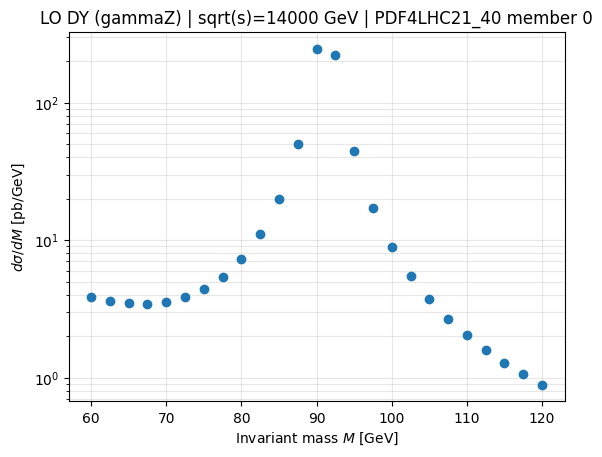

In [6]:

plt.figure()
plt.errorbar(M_grid, dsig, yerr=dsig_err, fmt="o", capsize=2)
plt.yscale("log")
plt.xlabel(r"Invariant mass $M$ [GeV]")
plt.ylabel(r"$d\sigma/dM$ [pb/GeV]")
plt.title(f"LO DY ({mode}) | sqrt(s)={sqrt_s:g} GeV | {pdf_set_name} member {replica}")
plt.grid(True, which="both", alpha=0.3)
plt.show()



## Quick PDF member comparison (optional)

This repeats the spectrum for a few PDF members. For speed, consider loosening `epsrel` or reducing `nM`.


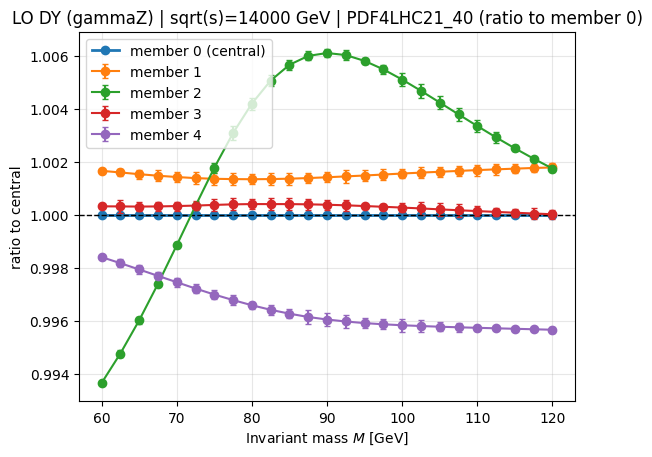

In [8]:

members_to_compare = [0, 1, 2, 3, 4]  # must be < len(pdfs)
mode = "gammaZ"

curves = {}
for m in members_to_compare:
    pdf_m = pdfs[m]
    vals = []
    errs = []
    for M in M_grid:
        v, e = dsigma_dM(M, pdf_m, mode=mode, epsrel=2e-4)  # slightly looser for speed
        vals.append(v); errs.append(e)
    curves[m] = (np.array(vals), np.array(errs))

plt.figure()
central_vals, central_errs = curves[0]

for m, (vals, errs) in curves.items():
    # compute ratio to central and propagate errors (assuming independent)
    with np.errstate(divide='ignore', invalid='ignore'):
        ratio = vals / central_vals
        rel_err = np.zeros_like(vals)
        rel_err_c = np.zeros_like(central_vals)
        mask_vals = vals > 0
        mask_c = central_vals > 0
        rel_err[mask_vals] = errs[mask_vals] / vals[mask_vals]
        rel_err_c[mask_c] = central_errs[mask_c] / central_vals[mask_c]
        ratio_err = ratio * np.sqrt(rel_err**2 + rel_err_c**2)

    if m == 0:
        # plot central as a thicker line (no error bars needed)
        plt.plot(M_grid, ratio, marker="o", linestyle="-", lw=2, label=f"member {m} (central)")
    else:
        plt.errorbar(M_grid, ratio, yerr=ratio_err, marker="o", linestyle="-", capsize=2, label=f"member {m}")

plt.axhline(1.0, color="k", linestyle="--", linewidth=1)
plt.xlabel(r"Invariant mass $M$ [GeV]")
plt.ylabel("ratio to central")
plt.title(f"LO DY ({mode}) | sqrt(s)={sqrt_s:g} GeV | {pdf_set_name} (ratio to member 0)")
plt.grid(True, which="both", alpha=0.3)
plt.legend()
plt.show()



## Notes / extensions

- Add **binning** and save tables (CSV/Parquet).
- Add a simple **QCD K-factor** as a multiplicative correction.
- Add **acceptance cuts** by keeping the angular dependence (go beyond inclusive LO).
- For very high \(M\), you may want to tighten `epsrel` and/or increase `limit`.
